<!--NOTEBOOK_HEADER-->
*This notebook contains material from [CBE40455-2020](https://jckantor.github.io/CBE40455-2020);
content is available [on Github](https://github.com/jckantor/CBE40455-2020.git).*


<!--NAVIGATION-->
< [7.1 Measuring Return](https://jckantor.github.io/CBE40455-2020/07.01-Measuring-Return.html) | [Contents](toc.html) | [7.3 Binomial Model for Pricing Options](https://jckantor.github.io/CBE40455-2020/07.03-Binomial-Model-for-Pricing-Options.html) ><p><a href="https://colab.research.google.com/github/jckantor/CBE40455-2020/blob/master/docs/07.02-Geometric-Brownian-Motion.ipynb"> <img align="left" src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open in Colab" title="Open in Google Colaboratory"></a><p><a href="https://jckantor.github.io/CBE40455-2020/07.02-Geometric-Brownian-Motion.ipynb"> <img align="left" src="https://img.shields.io/badge/Github-Download-blue.svg" alt="Download" title="Download Notebook"></a>

# 7.2 Geometric Brownian Motion

This notebook presents methods for modeling a financial time series as geometric Brownian motion. The basic outline is to:

1. Capture a data series.
2. Compute returns (we'll do both linear and log returns).
3. Test statistical properties. We need the returns to be independent and identically distributed (iid).
4. Fit distribution of returns to a normal distribution.
5. Perform simulations.

## 7.2.1 Historical perspectives

The name [Brownian motion](http://physics.ucsc.edu/~drip/5D/brown/brown.pdf) (or Brownian movement) is a tribute to Sir Robert Brown, the Scottish botanist who, in 1827, reported  the random motion of pollen grains on the surface of water when viewed under a microscope. 

The explanation of that behavior waited for the genius of Albert Einstein. In the *[Annus mirabilis](https://en.wikipedia.org/wiki/Annus_mirabilis)* of 1905, while employed as a patent clerk and living in a [modest apartment in Bern](https://en.wikipedia.org/wiki/Annus_Mirabilis_papers#/media/File:Albert_einstein_house_bern.JPG), Einstein published papers describing Special Relativity, laid the foundation for quantum theory with a paper on the photoelectric effect, and demonstrated the existence of atoms and molecules with a paper on [Brownian Motion](https://www.zbp.univie.ac.at/dokumente/einstein2.pdf). 

Remarkably, five earlier [Louis Bachelier](https://en.wikipedia.org/wiki/Louis_Bachelier) published his Master's thesis on the "Theory of Speculation". While this study was limited to the dynamics of prices on the Paris Bourse, and therefore didn't have the profound implications for Physics of Einstein's forthcoming work, nevertheless Bachelier should be credited with introducing random motion to describe price dynamics. Unfortunately, this work laid in relative obscurity for decades.

Other figures in this intellectual history include the Japanese [Kiyosi Ito](https://en.wikipedia.org/wiki/Kiyosi_It%C3%B4) whose work in the difficult circumstances of the second World War [laid a foundation for stochastic calculus](http://www4.math.sci.osaka-u.ac.jp/shijodanwakai/pdf/1077.pdf). Later, the [eccentric](https://www.theatlantic.com/technology/archive/2014/06/norbert-wiener-the-eccentric-genius-whose-time-may-have-finally-come-again/372607/) [Norbert Weiner](https://en.wikipedia.org/wiki/Norbert_Wiener) established a [theory for random motion -- [the Wiener process](https://en.wikipedia.org/wiki/Wiener_process) -- now widely used in engineering and finance.

The colorful history of individual genius and iconclastic research doesn't end there, but it is enough to provide some understanding behind the terminology that will be introduced below.



## 7.2.2 Python Imports and Utility Functions

The [`pandas-datareader`](https://pandas-datareader.readthedocs.io/en/latest/#) package provides a utility for accessing on-line data sources of data. Since the interfaces to those data sources are constantly changing, the next cell updates any current installation of the data reader to the latest available version.

In [40]:
%%capture
#!pip install pandas_datareader --upgrade

In [41]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import datetime

import pandas as pd
import pandas_datareader as pdr

In [42]:
# python libraray for accessing internet resources
import requests

def lookup_yahoo(symbol):
    """Return a list of all matches for a symbol on Yahoo Finance."""
    url = f"http://d.yimg.com/autoc.finance.yahoo.com/autoc?query={symbol}&region=1&lang=en"
    return requests.get(url).json()["ResultSet"]["Result"]

def get_symbol(symbol):
    """Return exact match for a symbol."""
    result = [r for r in lookup_yahoo(symbol) if symbol == r['symbol']]
    return result[0] if len(result) > 0 else None

## 7.2.3 Statistical Properties of Returns

{'symbol': 'AAPL', 'name': 'Apple Inc.', 'exch': 'NMS', 'type': 'S', 'exchDisp': 'NASDAQ', 'typeDisp': 'Equity'}


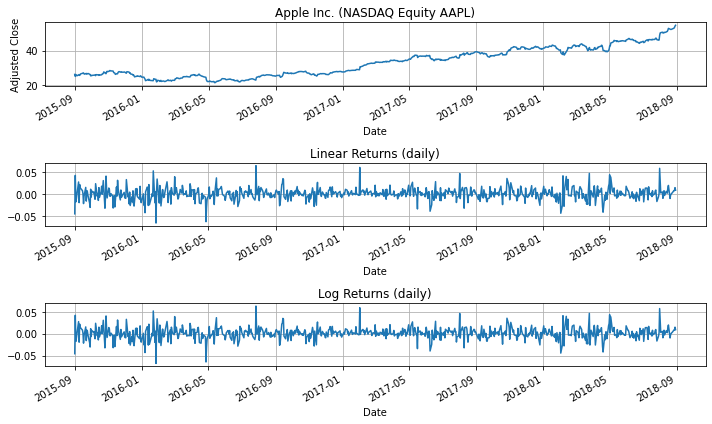

In [46]:
symbol = 'AAPL'

# get symbol data
symbol_data = get_symbol(symbol)
print(symbol_data)
assert symbol_data, f"Symbol {symbol} wasn't found."

# end date is today
end = datetime.datetime(2018, 8, 30).date()
start = end-datetime.timedelta(3*365)

# get stock price data
S = pdr.data.DataReader(symbol, "yahoo", start, end)['Adj Close']
rlin = (S - S.shift(1))/S.shift(1)
rlog = np.log(S/S.shift(1))

# clean up data
rlin = rlin.dropna()
rlog = rlog.dropna()

# plot data
plt.figure(figsize=(10,6))
plt.subplot(3,1,1)
title = f"{symbol_data['name']} ({symbol_data['exchDisp']} {symbol_data['typeDisp']} {symbol_data['symbol']})"
S.plot(title=title)
plt.ylabel('Adjusted Close')
plt.grid()

plt.subplot(3,1,2)
rlin.plot()
plt.title('Linear Returns (daily)')
plt.grid()
plt.tight_layout()

plt.subplot(3,1,3)
rlog.plot()
plt.title('Log Returns (daily)')
plt.grid()
plt.tight_layout()

### 7.2.3.1 Distribution of Returns

A basic assumption in developing developing stochastic price models is that the residuals are indepdendent and identically distributed (i.i.d.) random variates.  Here we show the results of several common statistical tests that would screen out non-i.i.d. random variates.

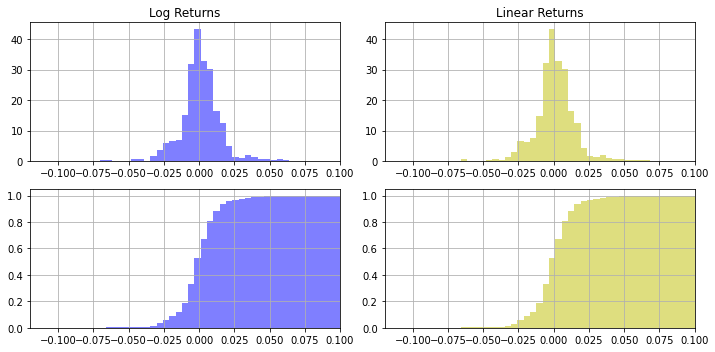

In [44]:
bins = np.linspace(-0.12,0.10,50)
plt.figure(figsize=(10,5))

plt.subplot(2,2,1)
rlog.hist(bins=bins, density=True, color='b', alpha=0.5)
plt.xlim(bins.min(),bins.max())
plt.title('Log Returns')

plt.subplot(2,2,3)
rlog.hist(bins=bins, density=True, cumulative=True, color='b',alpha=0.5)
plt.xlim(bins.min(),bins.max())

plt.subplot(2,2,2)
rlin.hist(bins=bins, density=True, color='y', alpha=0.5)
plt.xlim(bins.min(),bins.max())
plt.title('Linear Returns')

plt.subplot(2,2,4)
rlin.hist(bins=bins, density=True, cumulative=True, color='y',alpha=0.5)
plt.xlim(bins.min(),bins.max())

plt.tight_layout()

### 7.2.3.2 Distribution of First Half versus Second Half of the Data Set

Text(0.5, 1.0, 'Change in Distribution of Log Returns')

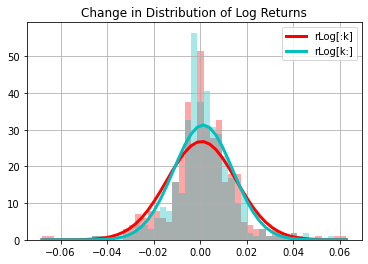

In [52]:
from scipy.stats import norm

k = int(len(rlog)/2)
r = np.linspace(rlog.min(),rlog.max())

plt.figure()

param = norm.fit(rlog[:k])
rlog[:k].hist(bins=r, density=True, alpha=0.35, color='r')
plt.plot(r,norm.pdf(r,loc=param[0],scale=param[1]),'r-',lw=3);

rlog[k:].hist(bins=r, density=True, alpha=0.35, color='c')
param = norm.fit(rlog[k:])
plt.plot(r,norm.pdf(r, loc=param[0], scale=param[1]), 'c-',lw=3);

plt.legend(['rLog[:k]', 'rLog[k:]'])
plt.title('Change in Distribution of Log Returns')

In [53]:
norm.fit(rlog[:k].dropna())

(0.0006336699156164701, 0.014878954780728938)

### 7.2.3.3 Lag Plot of $r^{log}_{t+1}$ versus $r^{log}_t$

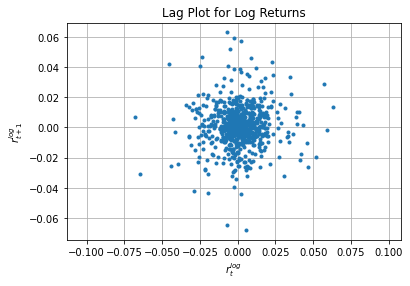

In [19]:
plt.plot(rlog[0:-1], rlog[1:],'.')
plt.axis('equal');
plt.xlabel('$r^{log}_{t}$')
plt.ylabel('$r^{log}_{t+1}$')
plt.grid()
plt.title('Lag Plot for Log Returns');

i.i.d. ==> Independent and Identically Distributed

### 7.2.3.4 Autocorrelation

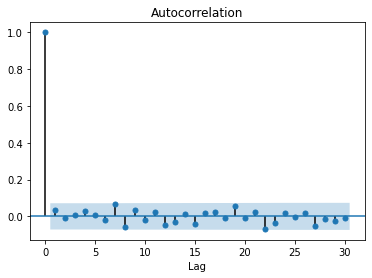

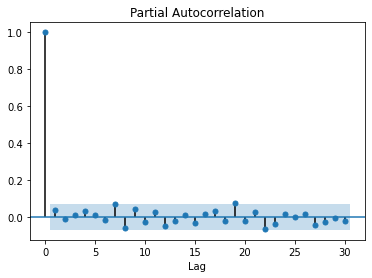

In [54]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
plot_acf(rlog, lags=min(30, len(rlog)));
plt.xlabel('Lag');
plot_pacf(rlog, lags=min(30, len(rlog)));
plt.xlabel('Lag');

## 7.2.4 Fitting Returns to a Distribution

### 7.2.4.1 Normal Distribution

0.0009849473520634352 0.01385565341496523


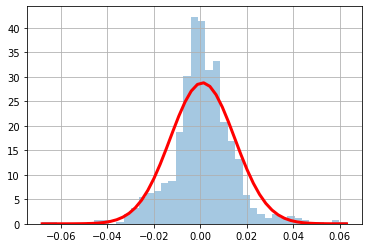

<Figure size 432x288 with 0 Axes>

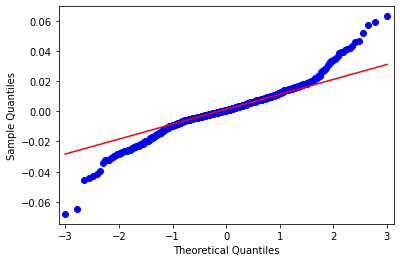

In [25]:
from scipy.stats import norm
from statsmodels.graphics.gofplots import qqplot

r = np.linspace(rlog.min(), rlog.max())

plt.figure()
param = norm.fit(rlog)
nu = param[0]
sigma = param[1]
print(nu, sigma)
rlog.hist(bins=int(1.5*np.sqrt(len(rlog))), density=True,alpha=0.4)
plt.plot(r, norm.pdf(r, loc=param[0], scale=param[1]), 'r-', lw=3)

plt.figure()
qqplot(rlog, line='q');

### 7.2.4.2 Student's T Distribution

(3.0986867048737174, 0.001039855273070818, 0.009090875385307088)


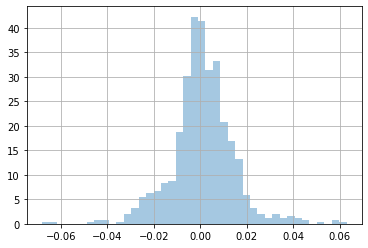

<Figure size 432x288 with 0 Axes>

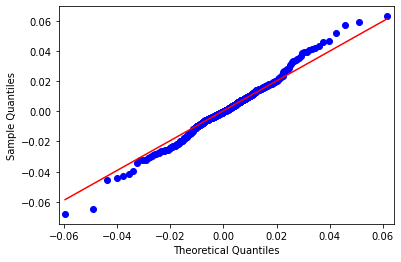

In [36]:
from scipy.stats import t
from statsmodels.graphics.gofplots import qqplot

r = np.linspace(rlog.min(), rlog.max())

plt.figure()
param = t.fit(rlog)
print(param)
dof = param[0]
nu = param[1]
sigma = param[2]

rlog.hist(bins=int(1.5*np.sqrt(len(rlog))), density=True, alpha=0.4)
#plt.plot(r, t.pdf(r, loc=param[0], scale=param[1]), 'r-', lw=3)

plt.figure()
qqplot(rlog, t,  distargs=(4,), loc=nu,  scale=sigma, line='q');

## 7.2.5 Geometric Brownian Motion

The basic notion behind this class of models is to recognize the return at each point in time, for example,

$$\frac{S_{k+1} - S_k}{S_k} = r^{lin}_{k+1}$$

can be expressed as the result of a random process. 

$$r^{lin}_{k+1} = \mu\Delta t + \sigma \sqrt{\Delta t}Z_{k+1}$$

where $Z_{k+1}$ comes from a Normal distribution with zero mean and a standard deviation of 1.

### 7.2.5.1 Linear Returns 

A discrete-time model for prices modeled as geometric Brownian motion is given by 

$$S_{k+1} = S_k + \mu S_k \Delta t + \sigma S_k \sqrt{\Delta t} Z_k$$

where $Z_k \sim N(0,1)$ and $\Delta t$ corresponds to a sampling period, typically a trading period. There are normally 252 trading days in a calendar year, 63 trading days in a quarter, and 21 trading days in a month.

Defining the linear return as

$$r^{lin}_{k} = \frac{S_k - S_{k-1}}{S_{k-1}} = \mu \Delta t + \sigma \sqrt{\Delta t} Z_k$$

then the statistical model for linear returns becomes

$$r^{lin}_{k} = \mu \Delta t + \sigma \sqrt{\Delta t} Z_k$$

This shows, for the case of Geometric Brownian Motion, $r^{lin}_k$ is a random variable drawn from a the normal distribution 

$$r^{lin}_k \sim N(\mu \Delta t, \sigma\sqrt{\Delta t})$$

### 7.2.5.2 Log Returns

Alternatively, geometric Brownian motion for prices can be modeled using the natural logarithm of price,

$$\ln S_{k+1} = \ln S_k + \nu \Delta t + \sigma \sqrt{\Delta t} Z_k$$

where, as for linear returns, $Z_k \sim N(0,1)$ and $\Delta t$ corresponds to a sampling period. The relationship between linear and log returns is given by 

$$\nu \approx \mu - \frac{\sigma^2}{2}$$

where $\frac{\sigma^2}{2}$ is the 'volatility drag' on linear returns. Defining log return as 

$$r^{log}_k = \ln S_k - \ln S_{k-1} = \nu \Delta t + \sigma \sqrt{\Delta t} Z_k$$

the statistical model for log returns becomes

\begin{align*}
r^{log}_{k} & = \nu \Delta t + \sigma \sqrt{\Delta t} Z_k \\
& \sim N(\nu \Delta t, \sigma\sqrt{\Delta t})
\end{align*}

This shows, for the case of Geometric Brownian Motion, $r^{log}_k$ is a random variable drawn from a the normal distribution. The following cells is a complete self-contained demonstration of downloading a data series, fitting a GBM price model, and performing simulations. The first cell loads a data series, computes linear and log returns, and estimates values for $\mu$, $\nu$, and $\sigma$.

In [55]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np

import pandas as pd
import datetime
from pandas_datareader import data, wb

import requests

def get_symbol(symbol):
    """
    get_symbol(symbol) uses Yahoo to look up a stock trading symbol and 
    return a description.
    """
    url = "http://d.yimg.com/autoc.finance.yahoo.com/autoc?query={}&region=1&lang=en".format(symbol)
    result = requests.get(url).json()
    for x in result['ResultSet']['Result']:
        if x['symbol'] == symbol:
            return x['name']

symbol = 'X'

# end date is today
end = datetime.datetime.today().date()
start = end-datetime.timedelta(3*365)

# get stock price data
S = data.DataReader(symbol,"yahoo",start,end)['Adj Close']

rlin = (S - S.shift(1))/S.shift(1)
rlog = np.log(S/S.shift(1))

rlin = rlin.dropna()
rlog = rlog.dropna()

print('Linear Returns')
mu,sigma = norm.fit(rlin)
print(f'   mu = {mu:12.8f}  (annualized = {100*252*mu:.2f}%)')
print(f'sigma = {0:12.8f}  (annualized = {1:.2f}%)'.format(sigma,100*np.sqrt(252)*sigma))
print()

print('Log Returns')
nu,sigma = norm.fit(rlog)
print('   nu = {0:12.8f}  (annualized = {1:.2f}%)'.format(nu,100*252*nu))
print('sigma = {0:12.8f}  (annualized = {1:.2f}%)'.format(sigma,100*np.sqrt(252)*sigma))

Linear Returns
   mu =  -0.00061601  (annualized = -15.52%)
sigma =   0.00000000  (annualized = 1.00%)

Log Returns
   nu =  -0.00132993  (annualized = -33.51%)
sigma =   0.03786823  (annualized = 60.11%)


### 7.2.5.3 Forecasting

The second cell performs $N$ simulations over a time period $T$, and plots the results with the historical data.

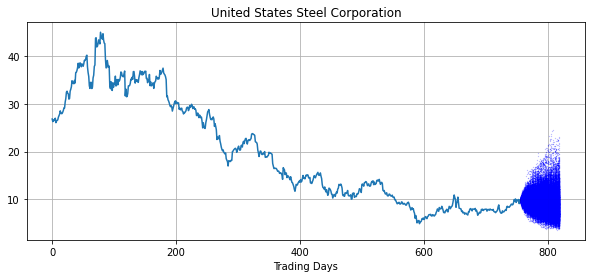

In [57]:
from scipy.stats import norm

N = 1000
T = 63
dt = 1

plt.figure(figsize=(10,4))
plt.plot(S.values)
plt.title(get_symbol(symbol))
plt.xlabel('Trading Days')

Slog = []  # log of final values
for n in range(0,N):
    P = S[-1]       # returns the last price in the sequence
    k = len(S)
    Plog = []
    tlog = []
    for t in range(len(S)+1,len(S)+T+1):
        Z = norm.rvs()
        P += P*(mu*dt + sigma*np.sqrt(dt)*Z)
        Plog.append(P)
        tlog.append(t)
    plt.plot(tlog,Plog,'b.',ms=0.4,alpha=0.5)
    Slog.append(P)

plt.grid()

0.30005648196687873 0.0 8.386063629075824


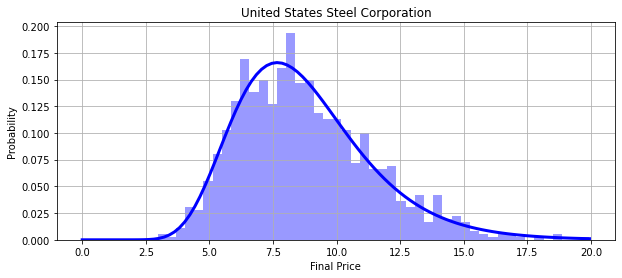

In [39]:
from scipy.stats import lognorm

plt.figure(figsize=(10, 4))
nbins = min(100, int(1.5*np.sqrt(N)))
plt.hist(Slog, bins=nbins, density=True, alpha=0.4, color='b');

shape, loc, scale = lognorm.fit(Slog, floc=0)
print(shape, loc, scale)
x=np.linspace(0, max(Slog), 100) 
pdf_fitted = lognorm.pdf(x, shape, loc=loc, scale=scale) # fitted distribution
plt.plot(x, pdf_fitted, 'b-', lw=3)
plt.xlabel('Final Price')
plt.ylabel('Probability');
plt.title(get_symbol(symbol))
plt.grid()

<!--NAVIGATION-->
< [7.1 Measuring Return](https://jckantor.github.io/CBE40455-2020/07.01-Measuring-Return.html) | [Contents](toc.html) | [7.3 Binomial Model for Pricing Options](https://jckantor.github.io/CBE40455-2020/07.03-Binomial-Model-for-Pricing-Options.html) ><p><a href="https://colab.research.google.com/github/jckantor/CBE40455-2020/blob/master/docs/07.02-Geometric-Brownian-Motion.ipynb"> <img align="left" src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open in Colab" title="Open in Google Colaboratory"></a><p><a href="https://jckantor.github.io/CBE40455-2020/07.02-Geometric-Brownian-Motion.ipynb"> <img align="left" src="https://img.shields.io/badge/Github-Download-blue.svg" alt="Download" title="Download Notebook"></a>